In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

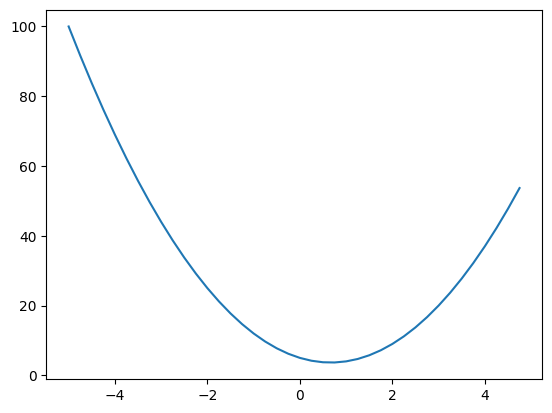

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [5]:
h = 0.000001
x = 4
(f(x+h)-f(x))/h

20.000002990627763

In [6]:
#more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b+c
print(d)

4.0


In [7]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b+c
c+=h
d2 = a*b+c
print('d1', d1)
print('d2', d2)
print('slope: ', (d2-d1)/h)

d1 4.0
d2 4.0001
slope:  0.9999999999976694


In [8]:
class Value:
    def __init__(self,data, _children=(),_op='', label = ''):
        self.data= data
        self.grad = 0.0
        self._backward = lambda:None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data+other.data,(self,other),'+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        
        return out
    def __mul__(self,other):    
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data*other.data, (self,other),'*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self,other):
        assert isinstance(other,(int,float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other *(self.data **(other-1)) *out.grad
        out._backward = _backward
        return out

    def __rmul__(self,other): #other * self
        return self * other

    def __truediv__(self,other): # self/other
        return self*other**-1

    def __neg__(self): #-self
        return self*-1

    def __sub__(self,other): # self-other
        return self +(-other
                     )
    def __radd__(self, other): # other + self
        return self + other

        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1-t**2)*out.grad
        out._backward=_backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
            


In [9]:
a = Value(2.0)
b = Value(4.0)
b/a

Value(data=2.0)

In [10]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data,n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


In [11]:
#inputs x1,x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
#weights w1,w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label ='w2')
#bias of the neuron
b = Value(6.8813735870195432, label = 'b')
#x1*w1 +x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 +b ; n.label = 'n'
o = n.tanh();o.label= 'o'
o.backward()

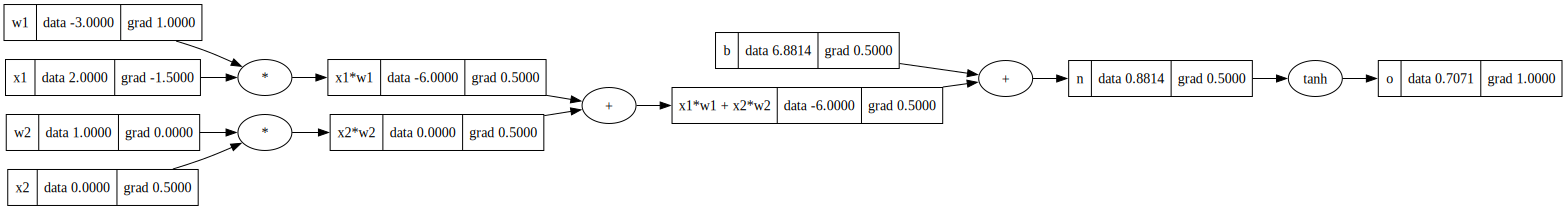

In [12]:
draw_dot(o)

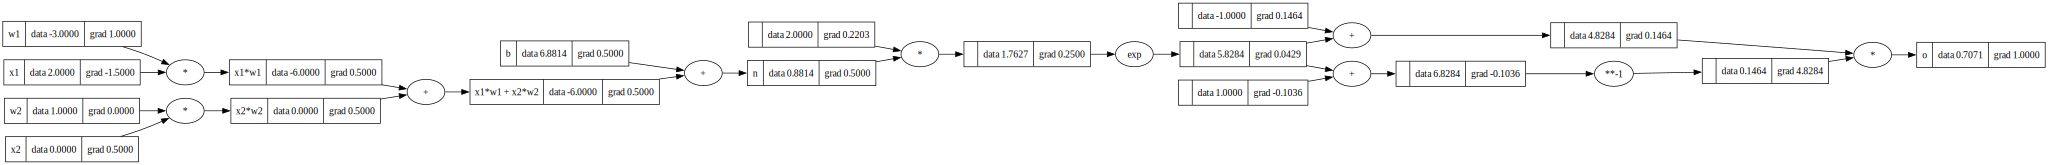

In [13]:
#inputs x1,x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
#weights w1,w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label ='w2')
#bias of the neuron
b = Value(6.8813735870195432, label = 'b')
#x1*w1 +x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 +b ; n.label = 'n'
#------->
e = (2*n).exp()
o= (e-1)/(e+1)
#---------<
o.label= 'o'
o.backward()
draw_dot(o)

In [14]:
import torch

In [15]:
import torch

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('—'*10)
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
——————————
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [16]:
torch.Tensor([[1,2,3],[4,5,6]]).shape

torch.Size([2, 3])

In [17]:
import random

In [18]:
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self,x):
        # w * x + b
        act = sum(wi*xi for wi, xi in zip(self.w,x)) + self.b
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

        

In [19]:
x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=0.2269486785126117)

In [20]:
n.parameters()

[Value(data=0.03813363628512878),
 Value(data=-0.8746432091580947),
 Value(data=0.31854884441785813),
 Value(data=0.8131197570936051),
 Value(data=0.7709560989121662),
 Value(data=0.9551344260235466),
 Value(data=0.8613525145386958),
 Value(data=-0.7080677193659144),
 Value(data=-0.6922433821014793),
 Value(data=-0.8483948268260173),
 Value(data=0.08422651512536738),
 Value(data=0.5721536139398065),
 Value(data=-0.8843539557768081),
 Value(data=-0.9740186958553805),
 Value(data=-0.8697985317739192),
 Value(data=-0.798132436090526),
 Value(data=0.34380089329130437),
 Value(data=-0.15302243894641787),
 Value(data=0.3825375531180295),
 Value(data=0.4124022457336116),
 Value(data=0.5355005330750604),
 Value(data=-0.025610634077832817),
 Value(data=-0.009797911293915051),
 Value(data=0.19059194767552),
 Value(data=-0.2595078633168666),
 Value(data=-0.5662513099613637),
 Value(data=0.1980779815207978),
 Value(data=-0.9424482842164685),
 Value(data=0.3420256060547511),
 Value(data=-0.32266676

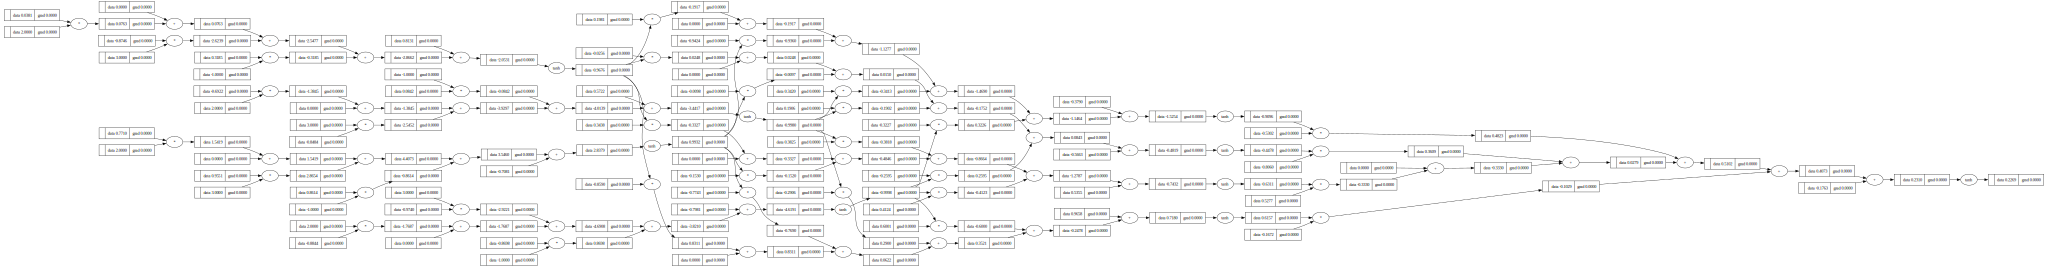

In [21]:
draw_dot(n(x))

In [22]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]
ys = [1.0,-1.0,-1.0,1.0] # desired targets

In [219]:
for k in range(20):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))

    #backward pass 
    for p in n.parameters():
        p.grad =0.0
    loss.backward()

    #update
    for p in n.parameters():
        p.data += -0.1*p.grad
    print(k, loss.data)


0 6.556220881727293e-05
1 6.542147203912083e-05
2 6.528148013599672e-05
3 6.514222685005637e-05
4 6.500370599448455e-05
5 6.486591145248962e-05
6 6.47288371763056e-05
7 6.459247718621981e-05
8 6.445682556961742e-05
9 6.432187648003336e-05
10 6.418762413623e-05
11 6.405406282128061e-05
12 6.392118688167825e-05
13 6.378899072645628e-05
14 6.36574688263161e-05
15 6.352661571278103e-05
16 6.339642597734986e-05
17 6.326689427068875e-05
18 6.313801530180533e-05
19 6.300978383725595e-05


In [220]:
n.parameters()

[Value(data=-0.2336769480003655),
 Value(data=-0.7953923241371658),
 Value(data=1.247046968830672),
 Value(data=0.8690216509091973),
 Value(data=0.6923124505081633),
 Value(data=1.6267962799810411),
 Value(data=0.31396340115836696),
 Value(data=-0.4741816911866553),
 Value(data=-0.611991352891057),
 Value(data=-0.800157410049939),
 Value(data=0.4565824948282932),
 Value(data=0.698398621047398),
 Value(data=-0.7364360524963244),
 Value(data=-0.7743629898679583),
 Value(data=-1.0869451230116545),
 Value(data=-0.6484137613264469),
 Value(data=-2.2960188118137412),
 Value(data=-1.647766612934077),
 Value(data=0.40797524714064215),
 Value(data=1.445104114251795),
 Value(data=-0.33642142200829345),
 Value(data=3.9648478793319755),
 Value(data=1.4950083603683029),
 Value(data=0.777884250744287),
 Value(data=-1.1132597908932924),
 Value(data=0.10850474623401293),
 Value(data=1.4802451402754446),
 Value(data=-0.14392837421083),
 Value(data=0.41550869896566267),
 Value(data=-0.7252199199876216),

In [221]:
ypred

[Value(data=0.9944171825802308),
 Value(data=-0.9968220629724153),
 Value(data=-0.9994777886356543),
 Value(data=0.9953664327959517)]

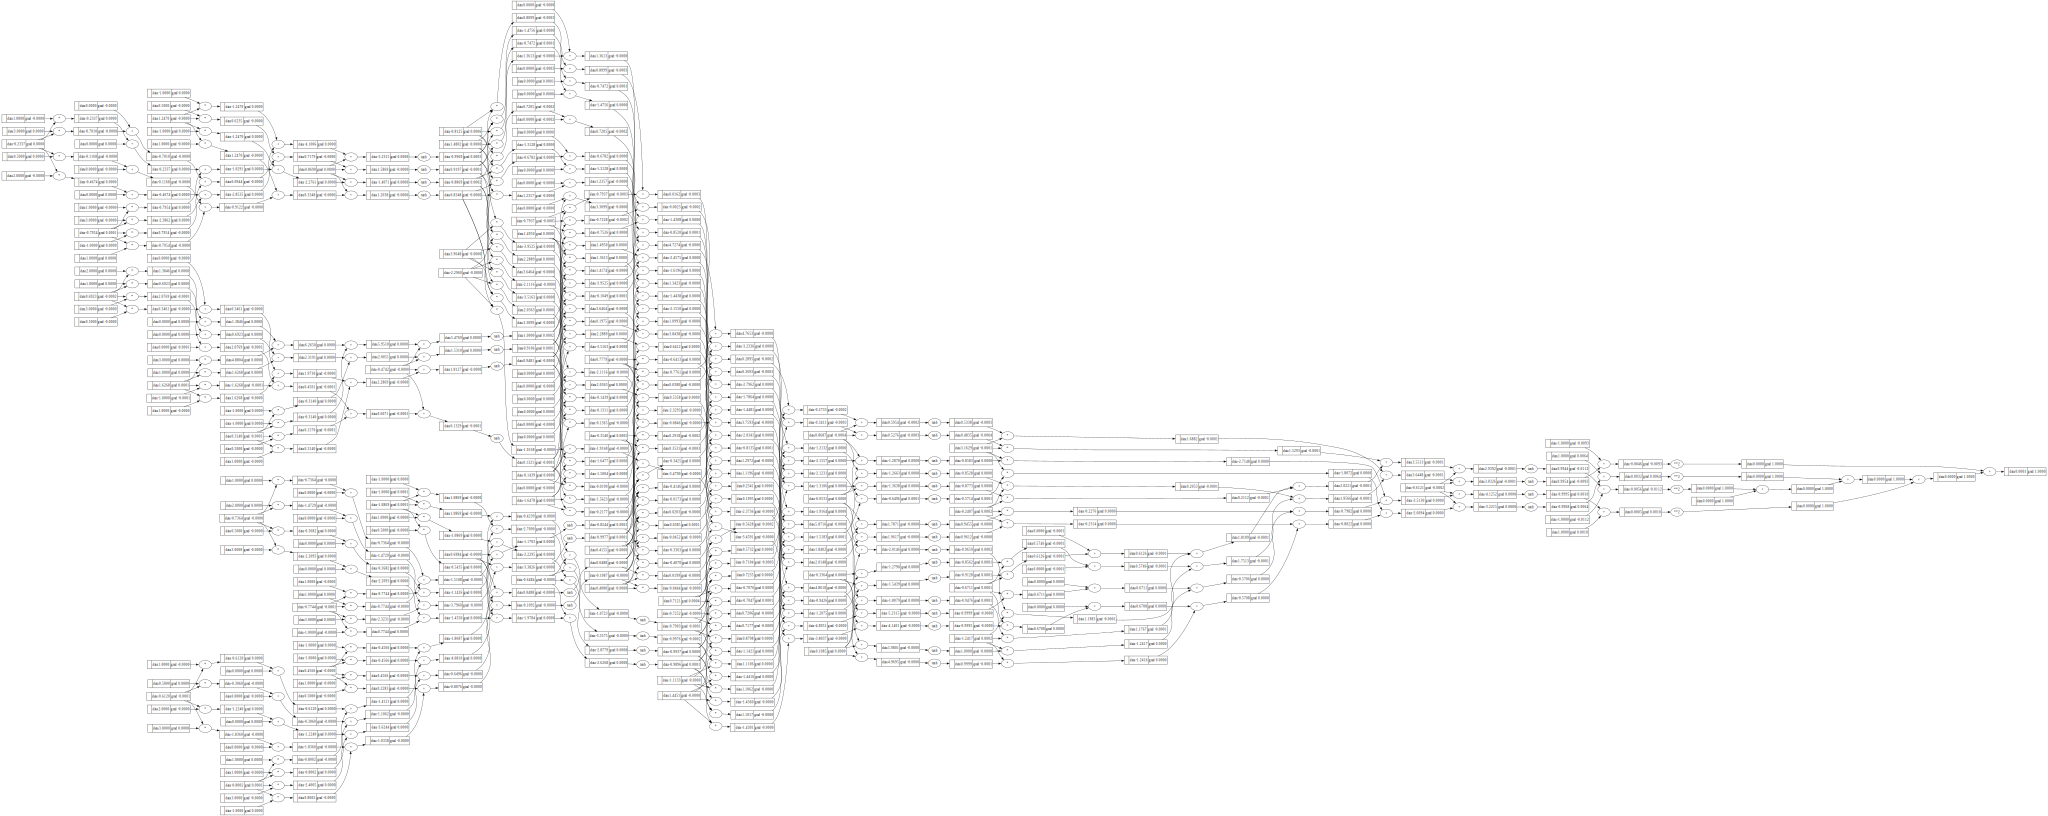

In [222]:
draw_dot(loss)